<center> <h1> Iterative Solver With Gap Safe Rules </h1> </center>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy import linalg
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

One chooses Coordinate Descent as iterative solver.
The idea of coordinate descent is to decompose a large optimisation
problem into a sequence of one-dimensional optimisation problems.
Coordinate descent methods have become unavoidable
in machine learning because they are very efficient for key problems,
namely Lasso, Logistic Regression and Support Vector Machines.
Moreover, the decomposition into small subproblems means that
only a small part of the data is processed at each iteration and
this makes coordinate descent easily scalable to high dimensions.
The idea of coordinate gradient descent is to perform
one iteration of gradient in the 1-dimensional problem
instead of solving it completely. In general it reduces drastically
the cost of each iteration while keeping the same convergence behaviour.

## Data Simulation 

In [0]:
def simu(beta, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(beta)
    cov = toeplitz(corr ** np.arange(0, n_features))

    # Features Matrix
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

    # Target labels vector with noise
    y = X.dot(beta) + randn(n_samples)

    if for_logreg:
        y = np.sign(y)

    return X, y

## Test

In [0]:
np.random.seed(0)
n_features = 100
beta = np.random.randn(n_features)

X, y = simu(beta, n_samples=1000, corr=0.5, for_logreg=False)

# print("Features matrix X : ", X)
# print("Target vector y : ", y)

## Plot

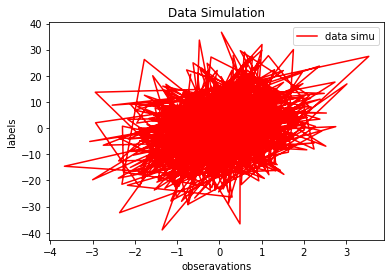

In [0]:
plt.plot(X[:,1], y, label='data simu', color='r')
# plt.yscale('log')
plt.title("Data Simulation")
plt.xlabel('obseravations')
plt.ylabel('labels')
plt.legend(loc='best')
plt.show()

## Minimization of the Primal Problem with Coordinate Descent Algorithm

In [0]:
def cyclic_coordinate_descent(X, y, n_iter=10):
    """Solver : cyclic coordinate descent

    Parameters
    ----------

    X: numpy.ndarray, shape (n_samples, n_features)
       features matrix

    y: numpy.array, shape (n_samples, )
       target labels vector

    n_iter: int, default = 10
            number of iterations

    Returns
    -------

    beta: numpy.array, shape(n_features,)
          parameters vector

    all_objs: numpy.array, shape(n_features)
              residuals vector

    """

    # Initialisation of the parameters

    n_samples, n_features = X.shape
    all_objs = []

    beta = np.zeros(n_features)
    residuals = y - X.dot(beta)

    # Computation of the lipschitz constants vector

    lips_const = np.linalg.norm(X, axis=0)**2

    # Iterations of the algorithm
    for k in range(n_iter):

        # One cyclicly updates the i^{th} coordinate corresponding to the rest
        # in the Euclidean division by the number of features
        # This allows to always selecting an index between 1 and n_features
        i = k % n_features

        old_beta_i = beta[i].copy()
        step = 1/lips_const[i]
        reg = old_beta_i * X[:, i]
        grad = np.dot(X[:, i], residuals)

        # Update of the parameters
        beta[i] += step*grad

        # Update of the residuals
        if old_beta_i != beta[i]:
            residuals += np.dot(X[:, i], old_beta_i - beta[i])

        if k % n_features == 0:
            # If k % n_features == 0 then we have updated all the coordinates
            # This means that we have performed a whole cycle
            # One computes the objective function
            all_objs.append((residuals**2).sum()/2.)

    return beta, np.array(all_objs)

## Test

In [0]:
beta_hat_cyclic_cd, objs_cyclic_cd = \
        cyclic_coordinate_descent(X, y, n_iter=5000)
# print("Beta hat cyclic coordinate descent : ", beta_hat_cyclic_cd)
# print("Objective function at the optimum cd: ", objs_cyclic_cd)
beta_hat_ols, objs_ols, _, _ = np.linalg.lstsq(X, y)
# print("Beta hat OLS : \n", beta_hat_ols)
# print("Objective function for the optimum parameters ols: ", objs_ols)

(50,)
(1,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


## Plot 

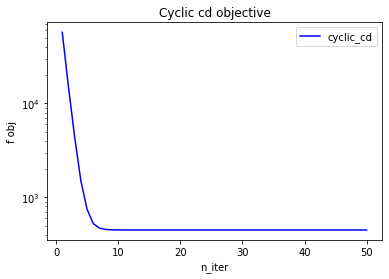

In [0]:
#import seaborn as sns
y = objs_cyclic_cd

x = np.arange(1, len(y)+1)

plt.plot(x, y, label='cyclic_cd', color='blue')
plt.yscale('log')
plt.title("Cyclic cd objective")
plt.xlabel('n_iter')
plt.ylabel('f obj')
plt.legend(loc='best')
plt.show()

## Theta Computation : Equation 11

In [0]:
def compute_theta_k(X, y, beta_k, lmbda):
    """Iterative computation of the dual optimal solution theta
      Dynamic Safe Rules

    Parameters
    ----------

    X: numpy.ndarray, shape = (n_samples, n_features)
      features matrix

    y: numpy.array, shape = (n_features, )
      target labels vector

    lmbda: numpy.array, shape = (n_iter, )
          regularization parameters vector

    beta_k: numpy.array, shape = (n_features, )
            primal optimal parameters vector

    Returns
    -------

    theta_k: float
            dual optimal parameters vector

    """

    # Initialization of the parameters
    # Residuals vector
    rho_k = y - np.dot(X, beta_k)
    # Proportionality constant
    a_k = np.dot(y.T, rho_k)/(lmbda*np.linalg.norm(rho_k)**2)
    b_k = -1/np.linalg.norm(np.dot(X.T, rho_k), np.inf)
    c_k = 1/np.linalg.norm(np.dot(X.T, rho_k), np.inf)

    alpha_k = min(max(a_k, b_k), c_k)
    # Dual optimal parameters vector
    theta_k = alpha_k * rho_k

    return theta_k


## Test

In [0]:
lmbda = 0.1
theta_k = compute_theta_k(X, y, beta_k=beta, lmbda=lmbda)

# print("Dual optimal paramters vector : ", theta_k)

## Computation of R hat : Theorem 2

In [0]:
def R_primal(X, y, beta, lmbda):
    """
    Parameters
    ----------

    X: numpy.ndarray, shape=(n_samples, n_features)
       features matrix

    y: numpy.array, shape=(n_samples, )
       target labels vector

    beta: numpy.array, shape=(n_features, )
          primal optimal parameters vector

    lmbda: float
           regularization parameter

    Returns
    -------

    R_hat_lmbda: float
                 primal radius of the dome
    """

    R_hat_lmbda = ((1/lmbda)*np.max(np.linalg.norm(y)**2
                   - np.linalg.norm(np.dot(X, beta) - y)**2
                   - 2*lmbda*np.linalg.norm(beta, 1), 0)**(1/2))

    return R_hat_lmbda

## Test

In [0]:
R_hat_lmbda = R_primal(X, y, beta, lmbda)

print("R primal (R_hat_lmbda) : \n", R_hat_lmbda)

R primal (R_hat_lmbda) : 
 3464.8358952601366


## Computation of R chech : Theorem 2

In [0]:
def R_dual(y, theta, lmbda):
    """
    Parameters
    ----------

    y: numpy.array, shape=(n_samples, )
       target labels vector

    theta: numpy.array, shape=(n_features, )
           dual optimal parameters vector

    lmbda: float
           regularization parameter

    Returns
    -------

    R_inv_hat_lmbda: float
                     dual radius of the dome
    """

    R_inv_hat_lmbda = np.linalg.norm(theta - y/lmbda)

    return R_inv_hat_lmbda


In [0]:
R_inv_hat_lmbda = R_dual(y, theta_k, lmbda)

print("R dual (R_inv_hat_lmbda) : \n", R_inv_hat_lmbda)

R dual (R_inv_hat_lmbda) : 
 3479.259836114735


## Radius of the safe sphere in closed form : Theorem 2

In [0]:
def radius_thm2(R_hat_lmbda, R_inv_hat_lmbda):
    """Compute the radius of the safe sphere region

    Parameters
    ----------

    R_hat_lmbda: float
                 primal radius of the safe dome region

    R_inv_hat_lmbda: float
                     dual radius of the safe dome region

    Returns
    -------
    r_lmbda: float
             radius of the safe sphere region
    """

    r_lmbda = np.sqrt(R_inv_hat_lmbda**2 - R_hat_lmbda**2)

    return r_lmbda


## Test


In [0]:
r_lmbda = radius_thm2(R_hat_lmbda, R_inv_hat_lmbda)
print("Radius of the safe sphere region r_lmbda : ", r_lmbda)

Radius of the safe sphere region r_lmbda :  316.4825842254526


## Mu function applied to the safe sphere in closed form : Equation 9

In [0]:
def mu_B(x_j, c, r):
    """Function mu applied to the sphere of center c and radius r
       for the jth feature X[:,j]

    Parameters
    ----------
    x_j: numpy.array, shape=(n_samples, )
         jth feature X[:,j]

    c: float
       center of the sphere

    r: float
       radius of the sphere

    Returns
    -------

    mu: float
        maximum value between the scalar products of theta and x_j
        and theta and -x_j
    """

    mu = abs(np.dot(x_j.T, c)) + r*np.linalg.norm(x_j)

    return mu

## Test

In [0]:
x_1 = X[:, 1]
c = np.random.randn(x_1.shape[0])
r = 1
mu = mu_B(x_1, c, r)

print("mu value : ", mu)

mu value :  53.95693770296334


## Maximization of the dual problem : Equation 2

In [0]:
def dual_solver(X, y, beta_hat, lmbda):
    """Maximization of the dual problem
       Orthogonal projection of the center of the safe sphere
       onto the feasible set

    Parameters
    ----------
    X: numpy.ndarray, shape = (n_samples, n_features)
       features matrix

    y: numpy.array, shape = (n_samples, )
       target labels vector

    beta_hat: numpy.array shape = (n_features, )
              current primal optimal parameters vector

    lmbda: float
           regularization parameter

    Returns
    -------

    theta_hat: numpy.array, shape = (n_samples, )
               dual optimal parameters vector

    """

    # Link equation : Equation 3
    residus = (y - np.dot(X, beta_hat))/lmbda

    # Orthogonal projection of theta_hat onto the feasible set
    theta_hat = residus / max(np.max(np.abs(residus)), 1)

    return theta_hat

## Test

In [0]:
theta_hat = dual_solver(X, y, beta_hat_cyclic_cd, lmbda)
# print("Dual optimal parameters vector theta_hat : ", theta_hat)

## Active set and zero set : Equation 7

In [0]:
def active_set_vs_zero_set(X, c, r):
    """
    Parameters
    ----------
    X: numpy.ndarray, shape = (n_samples, n_features)
       features matrix

    c: numpy.array, shape = (n_samples, )
       center of the safe sphere

    r: float
       radius of the safe sphere

    Returns
    -------
    A_C: numpy.array, shape = (n_idx_active_features, )
         active set : contains the indices of the relevant features

    Z_C: numpy.array, shape = (n_idx_zero_features, )
         zero set : contains the indices of the irrelevant features
    """
    A_C = []
    Z_C = []
    p = X.shape[1]
    for j in range(p):
        x_j = X[:, j]
        mu = mu_B(x_j, c, r)
        if mu >= 1:
            A_C.append(j)
        else:
            Z_C.append(j)

    return A_C, Z_C



## Test


In [0]:
c = theta_hat
r = 0.00000001
A_C, Z_C = active_set_vs_zero_set(X, c, r)

print("Active Set : ", A_C)
print("Zero Set : ", Z_C)

Active Set :  []
Zero Set :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


## Sign Function 

In [0]:
def sign(x):
    """
    Parameters
    ----------
    x: float

    Returns
    -------
    s: sign int
      (-1) if x < 0,, (+1) if x > 0, 0 if x = 0
    """

    if x > 0:
        s = 1
    elif x < 0:
        s = -1
    else:
        s = 0

    return s

## Soft-Thresholding Function

In [0]:
def soft_thresholding(u, x):
    """
    Parameters
    ----------
    u: float
      threshold

    x: float

    Returns
    -------
    ST: float
        0 between -u and +u or slope of the straight line x - u otherwise

    """

    ST = sign(x)*np.max(np.abs(x) - u, 0)

    return ST

## Primal Problem : Equation 1

In [0]:
def primal_pb(X, y, beta, lmbda):
    """
    Parameters
    ----------
    X: numpy.ndarray, shape = (n_samples, n_features)
       features matrix

    y: numpy.array, shape = (n_samples, )
       target labels vector

    beta: numpy.array, shape = (n_features, )
          initial vector of primal parameters

    lmbda: float
           regularization parameter

    Returns
    -------

    P_lmbda: float
             value of the primal problem for a given beta vector
    """

    P_lmbda = ((1/2)*np.linalg.norm(np.dot(X, beta) - y, 2)**2
               + lmbda*np.linalg.norm(beta, 1))

    return P_lmbda

## Test

In [0]:
P_lmbda = primal_pb(X, y, beta_hat_cyclic_cd, lmbda)

print("Value of the primal problem at the optimum : ", P_lmbda)

Value of the primal problem at the optimum :  457.7539610238181


## Dual Problem : Equation 2

In [0]:
def dual_pb(y, theta, lmbda):
    """
    Parameters
    ----------
    y: numpy.array, shape = (n_features, )

    theta: numpy.array, shape = (n_samples, )
           initial vector of dual parameters

    lmbda: float
           regularization parameter

    Returns
    -------

    D_lmbda: float
             value of the dual problem for a given theta vector
    """

    D_lmbda = ((1/2)*np.linalg.norm(y, ord=2)**2
               - ((lmbda**2)/2)*np.linalg.norm(theta - y/lmbda, ord=2)**2)

    return D_lmbda

## Test

In [0]:
D_lmbda = dual_pb(y, theta_hat, lmbda)
print("Value of the dual problem at the optimum : ", D_lmbda)

Value of the dual problem at the optimum :  28.15967324146186


## Duality Gap : Equation 2

In [0]:
def duality_gap(P_lmbda, D_lmbda):
    """
    Parameters
    ----------

    P_lmbda: float
             value of the primal problem at the optimum beta_hat

    D_lmbda: float
             value of the dual problem at the optimum theta_hat

    Returns
    -------
    G_lmbda: float
             duality gap between the primal optimal and the dual optimal

    """

    # Duality gap
    # If it is equal to 0 then the primal optimal is equal to the dual optimal
    # and the strong duality holds
    # If there exists a gap between the primal optimal and the dual optimal
    # then one only has the weak duality with P_lmbda >= D_lmbda
    G_lmbda = P_lmbda - D_lmbda

    return G_lmbda


## Test

In [0]:
G_lmbda = duality_gap(P_lmbda, D_lmbda)

print("Duality gap at the optimum : ", G_lmbda)

Duality gap at the optimum :  429.5942877823562


## Gap Safe Sphere : Equation 18

In [0]:
def gap_safe_sphere(X, c, r):
    """
    Parameters
    ----------

    X: numpy.ndarray, shape = (n_samples, n_features)
       features matrix

    c: numpy.array, shape = (n_samples,)
       center of the sphere

    r: float
       radius of the sphere

    Returns
    -------

    C_k: interval
         sphere of center c and of radius r
    """

    n, p = X.shape

    C_k = []

    for j in range(p):
        if np.linalg.norm(X[:, j] - c) <= r:
            C_k.append(j)

    return C_k

## Test

In [0]:
r = 100
c = theta_hat
C_k = gap_safe_sphere(X, c, r)
print("Safe Sphere : ", C_k)

Safe Sphere :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


## Coordinate Descent With Gap Safe Rules Algorithm : Algorithm 1

In [0]:
def cd_with_gap_safe_rules(X, y, epsilon, K, f, lmbda, T, lmbda_max):
    """Coordinate descent with gap safe rules

    Parameters
    ----------
    X: numpy.ndarray, shape = (n_samples, n_features)
       features matrix

    y: numpy.array, shape = (n_features, )
       target labels vector

    epsilon: float
             accuracy

    T: int
       number of epochs

    K: int
       number of iterations

    f: int
       frequency

    lmbda: numpy.array, shape = (T-1, )
           regularization parameters vector

    Returns
    -------

    beta_lmbda: numpy.array, shape = (n_features, )
                primal optimal parameters vector
                for the regularization parameter lmbda_t for t from 1 to T-1

    """

    # Initialization
    lmbda = []
    lmbda[0] = lmbda_max
    beta = dict()
    beta["lmbda0"] = 0

    for t in range(T-1):
        beta = beta["lambda" & (t-1)]

        for k in range(K):
            if k % f == 1:

              # Computation of theta
              # Equation 11
              theta_k = compute_theta_k(X, y, beta, lmbda)
              # Equation 18 : Safe Sphere

              # Equation Active Set Theorem 1
              A_C, Z_C = active_set_vs_zero_set(X)


            if G_lmbda(beta, theta) <= epsilon:
                beta_lmbda = beta
                break

        for j in A_C:
            beta_j = soft_thresholding(lmbda_t/np.linalg.norm(X[:,j])**2,
                     beta_j - (np.dot(X[:,j].T,
                     (np.dot(X, beta) - y))/np.linalg.norm(X[:,j])**2))

    return beta_lmbda_t